For some reason, we're not seeing the improvement in constraining power as we go to larger volumes. Here we investigate the data vectors to see what could be going wrong.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
from os.path import join
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
mpl.style.use('./style.mcstyle')   # noqa
import numpy as np
import torch
import seaborn as sns
import pandas as pd
import warnings
from tqdm import tqdm
import h5py

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:

# galaxies
modeldir = '/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm_hodzbias/models/galaxy/nbar+zPk0+zPk2+zPk4/kmin-0.0_kmax-0.4'
diagfile = '/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm_hodzbias/L2000-N256/663/diag/galaxies/hod00001.h5'
# sgc_lightcone
modeldir = '/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm_recnoise/models/sgc_lightcone/nbar+nz+Pk0+Pk2+Pk4/kmin-0.0_kmax-0.4'
diagfile = '/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm_recnoise/L2000-N256/663/diag/sgc_lightcone/hod00001_aug00001.h5'
xtest = np.load(join(modeldir, 'x_test.npy'))
thetatest = np.load(join(modeldir, 'theta_test.npy'))

thetarange = np.stack((thetatest.min(axis=0), thetatest.max(axis=0))).T
thetafid = np.mean(thetatest, axis=0)
thetafid

cosmonames = [r'$\Omega_m$', r'$\Omega_b$', r'$h$', r'$n_s$', r'$\sigma_8$']
template = xtest.mean(axis=0)
template_std = xtest.std(axis=0)

In [3]:
with h5py.File(diagfile, 'r') as f:
    k3D = f['Pk_k3D'][:]
kmin, kmax = 0.0, 0.4
k3D = k3D[(k3D >= kmin) & (k3D <= kmax)]
Nk = len(k3D)

Text(0.5, 0, '$k\\ [h/\\mathrm{Mpc}]$')

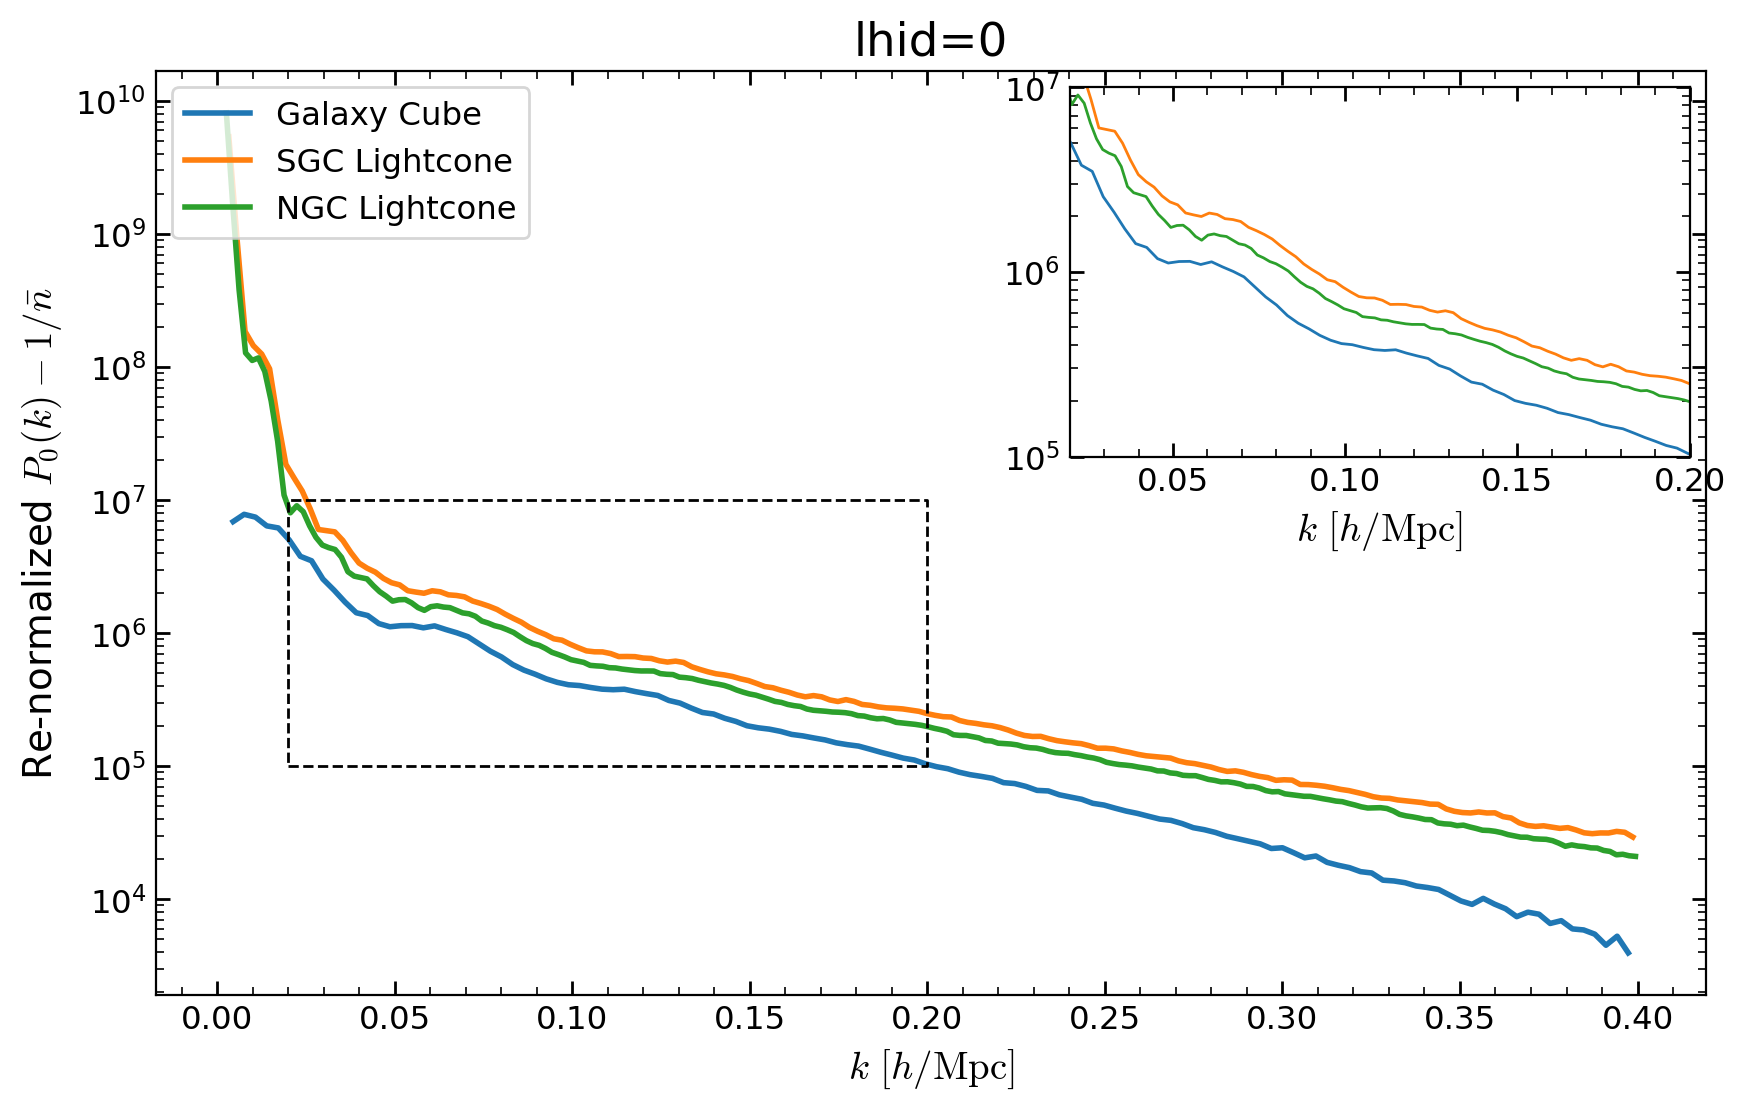

In [31]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def process_diagfile(diagfile):
    with h5py.File(diagfile, 'r') as f:
        if 'Pk_k3D' not in f:
            closest_a = min(list(f.keys()), key=lambda x: abs(float(x) - 0.666))
            f = f[closest_a]
        k3D = f['Pk_k3D'][:]
        Pk0 = f['Pk'][:, 0] - 1 / f.attrs['nbar']
    kmin, kmax = 0.0, 0.4
    mask = (k3D >= kmin) & (k3D <= kmax)
    return k3D[mask], Pk0[mask]


zoom_region = [[0.02, 0.2], [1e5, 1e7]]

lhid = 0
f, ax = plt.subplots(1, 1, figsize=(10, 6))
zax = inset_axes(ax, width="40%", height="40%", loc="upper right")

diagfile = '/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm_hodzbias/L2000-N256/'
diagfile += f'{lhid}/diag/galaxies/hod{lhid:04}1.h5'
k3D, Pk0 = process_diagfile(diagfile)
Pk0 *= 1e1
ax.semilogy(k3D, Pk0, label='Galaxy Cube')
zax.semilogy(k3D, Pk0, label='Galaxy Cube', lw=1)

diagfile = '/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm_recnoise/L2000-N256/'
diagfile += f'{lhid}/diag/sgc_lightcone/hod00001_aug00001.h5'
k3D, Pk0 = process_diagfile(diagfile)
ax.semilogy(k3D, Pk0, label='SGC Lightcone')
zax.semilogy(k3D, Pk0, label='SGC Lightcone', lw=1)

diagfile = '/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm_recnoise/L3000-N384/'
diagfile += f'{lhid}/diag/ngc_lightcone/hod00001_aug00001.h5'
k3D, Pk0 = process_diagfile(diagfile)
ax.semilogy(k3D, Pk0, label='NGC Lightcone')
zax.semilogy(k3D, Pk0, label='NGC Lightcone', lw=1)

ax.set(xlabel=r'$k\ [h/\mathrm{Mpc}]$',
       ylabel=r'Re-normalized $P_0(k) - 1/\bar{n}$')
ax.legend(loc='upper left')
ax.plot([zoom_region[0][0], zoom_region[0][1], zoom_region[0][1], zoom_region[0][0], zoom_region[0][0]],
        [zoom_region[1][0], zoom_region[1][0], zoom_region[1]
            [1], zoom_region[1][1], zoom_region[1][0]],
        color='k', linestyle='--', linewidth=1)
ax.set_title(f'lhid={lhid}')

# Customize the inset axis
zax.set_xlim(zoom_region[0])
zax.set_ylim(zoom_region[1])
zax.set_xlabel(r'$k\ [h/\mathrm{Mpc}]$')

Text(0.5, 0.98, 'nbar+nz+Pk0+Pk2+Pk4 sgc_lightcone')

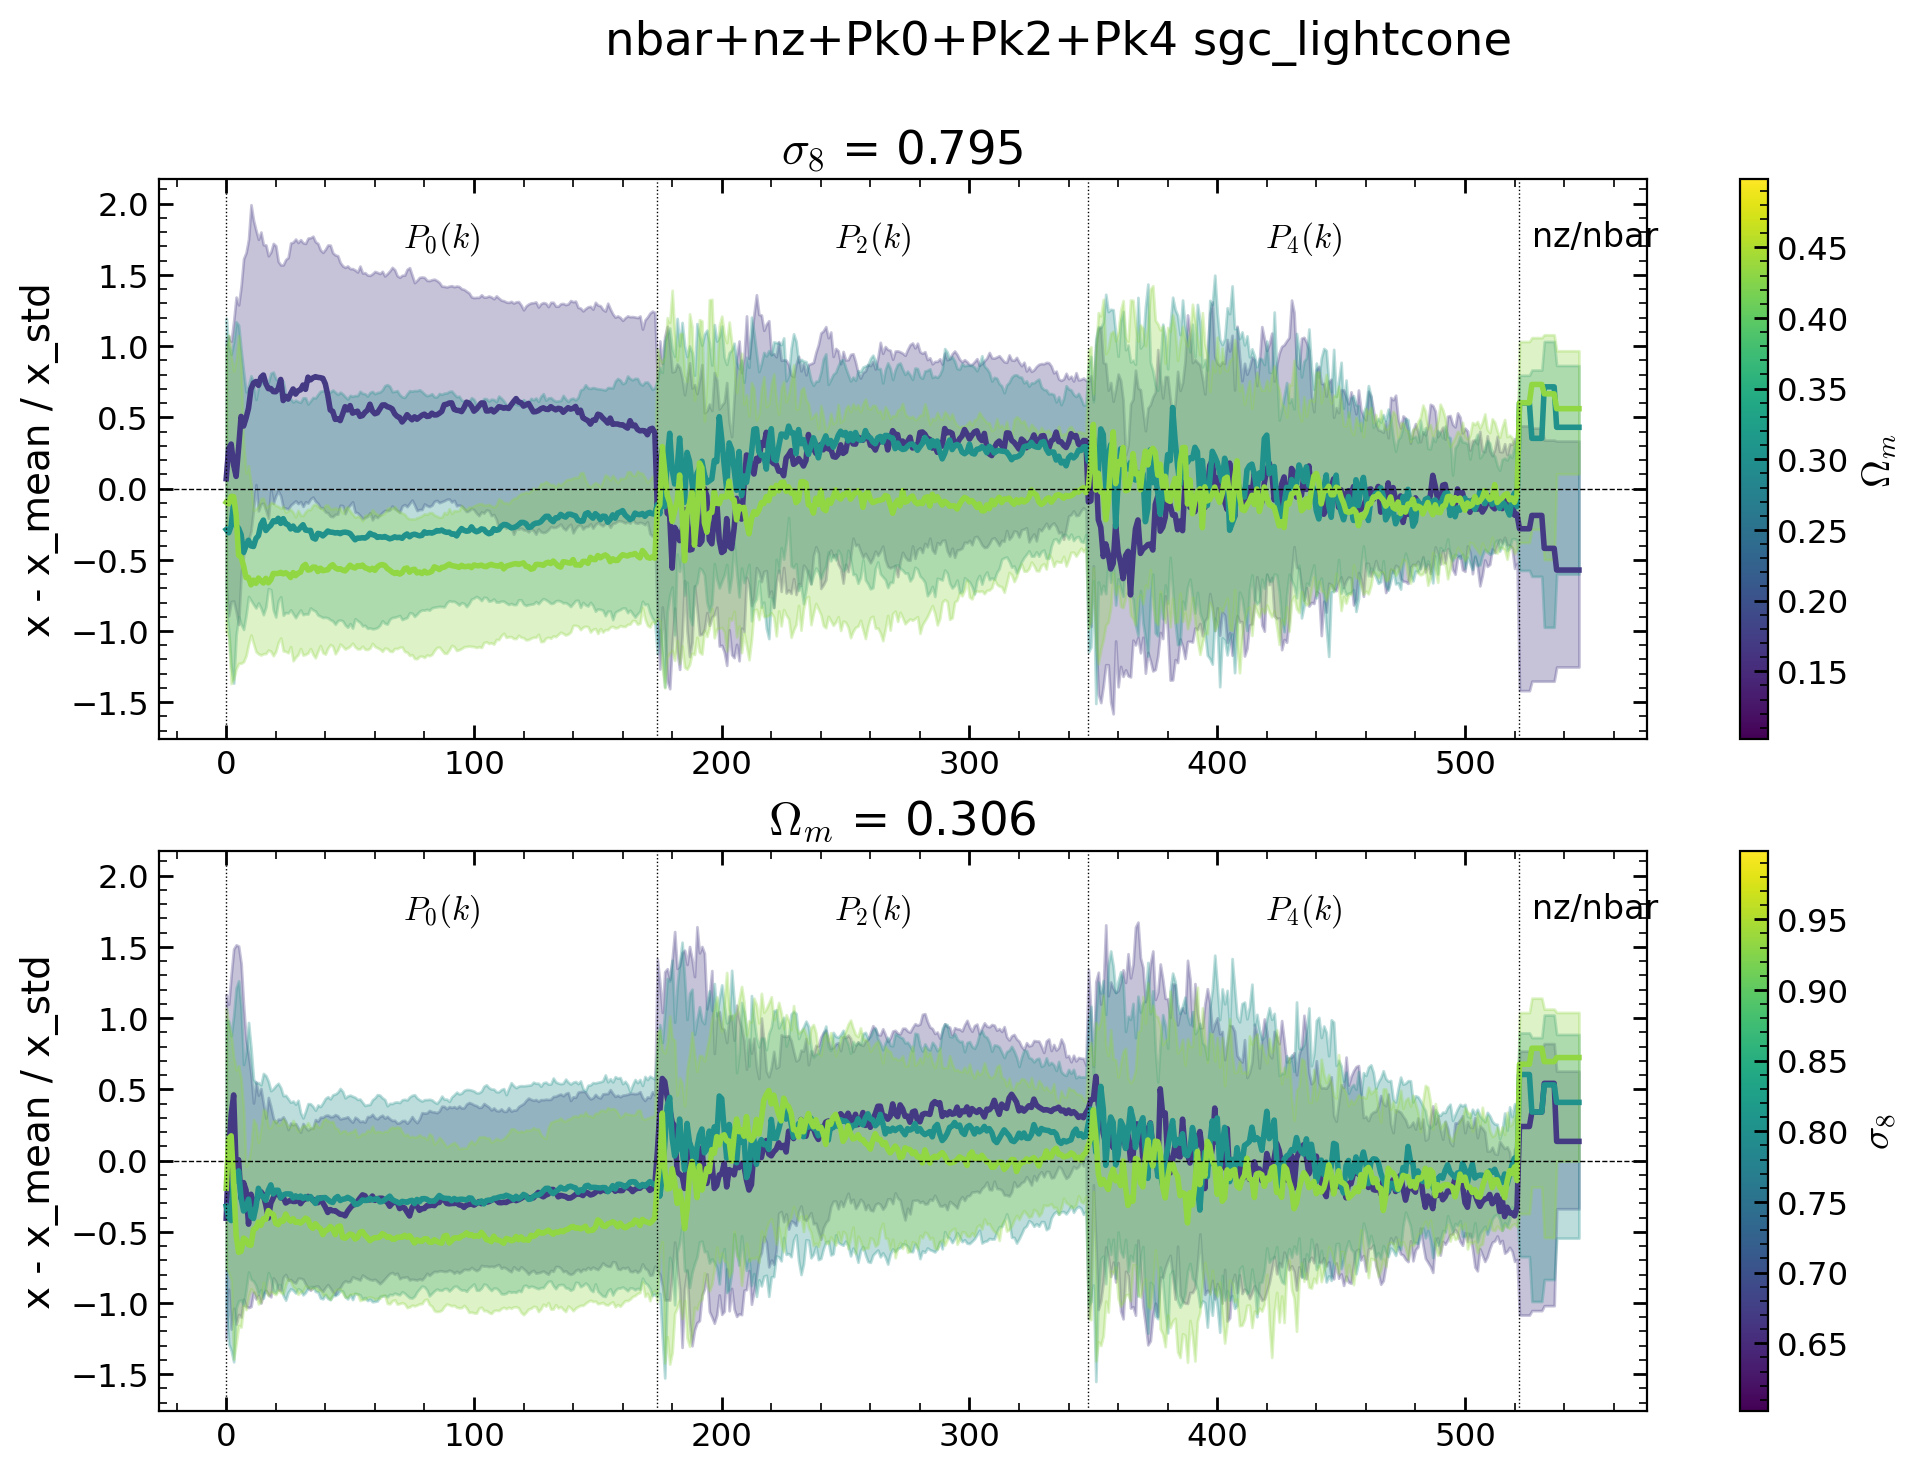

In [4]:
N = 200
Nbins = 3
f, axs = plt.subplots(2, 1, figsize=(12, 8), sharey=True)

ax = axs[0]

name = cosmonames[0]
k, l = 0, 4
norm = mpl.colors.Normalize(*thetarange[k])
selection = np.random.choice(np.argwhere(
    np.abs(thetatest[:, l] - thetafid[l]) < 0.05).flatten(), size=N, replace=False)
tbins = np.linspace(*thetarange[k], Nbins+1)
for i in range(len(tbins) - 1):
    mask = (thetatest[selection, k] >= tbins[i]) & (
        thetatest[selection, k] < tbins[i + 1])
    percs = np.percentile(
        (xtest[selection][mask]-template)/template_std, [16, 50, 84], axis=0)
    tmid = (tbins[i] + tbins[i + 1]) / 2
    ax.plot(percs[1], color=plt.cm.viridis(norm(tmid)), lw=2,
            label=f'{tbins[i]:.2f} - {tbins[i + 1]:.2f}')
    ax.fill_between(np.arange(len(percs[0])), percs[0], percs[2],
                    color=plt.cm.viridis(norm(tmid)), alpha=0.3)
f.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'),
           label=r'$\Omega_m$', ax=ax)
ax.set_title(f'{cosmonames[l]} = {thetafid[l]:.3f}')
ax.set_ylabel('x - x_mean / x_std')
for i in range(4):
    ax.axvline(i * Nk, color='k', ls=':', lw=0.5)
for i in range(3):
    ax.text(i * Nk + Nk / 2, 1.7, f'$P_{{{2*i}}}(k)$',
            horizontalalignment='center', fontsize=12, color='k')
ax.text(3*Nk + 5, 1.7, r'nz/nbar',
        horizontalalignment='left', fontsize=12, color='k')
ax.axhline(0, color='k', lw=0.5, ls='--')

ax = axs[1]
k, l = 4, 0
norm = mpl.colors.Normalize(*thetarange[k])
selection = np.random.choice(np.argwhere(
    np.abs(thetatest[:, l] - thetafid[l]) < 0.05).flatten(), size=N, replace=False)
tbins = np.linspace(*thetarange[k], Nbins+1)
for i in range(len(tbins) - 1):
    mask = (thetatest[selection, k] >= tbins[i]) & (
        thetatest[selection, k] < tbins[i + 1])
    percs = np.percentile(
        (xtest[selection][mask]-template)/template_std, [16, 50, 84], axis=0)
    tmid = (tbins[i] + tbins[i + 1]) / 2
    ax.plot(percs[1], color=plt.cm.viridis(norm(tmid)), lw=2,
            label=f'{tbins[i]:.2f} - {tbins[i + 1]:.2f}')
    ax.fill_between(np.arange(len(percs[0])), percs[0], percs[2],
                    color=plt.cm.viridis(norm(tmid)), alpha=0.3)
f.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'),
           label=r'$\sigma_8$', ax=ax)
ax.set_title(f'{cosmonames[l]} = {thetafid[l]:.3f}')
ax.set_ylabel('x - x_mean / x_std')
for i in range(4):
    ax.axvline(i * Nk, color='k', ls=':', lw=0.5)
for i in range(3):
    ax.text(i * Nk + Nk / 2, 1.7, f'$P_{{{2*i}}}(k)$',
            horizontalalignment='center', fontsize=12, color='k')
ax.text(3*Nk + 5, 1.7, r'nz/nbar',
        horizontalalignment='left', fontsize=12, color='k')
ax.axhline(0, color='k', lw=0.5, ls='--')

f.suptitle(modeldir.split('/')
           [-2] + (' galaxy' if 'galaxy' in modeldir else ' sgc_lightcone'))

In [37]:
xtrain = np.load(join(modeldir, 'x_train.npy'))
thetatrain = np.load(join(modeldir, 'theta_train.npy'))
print(xtrain.shape, thetatrain.shape)

(7914, 547) (7914, 5)


In [ ]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
import shap

# Train the Multi-Output XGBoost model
xgb_regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=1,
)

multi_output_model = MultiOutputRegressor(xgb_regressor)
multi_output_model.fit(xtrain, thetatrain)
target_names = cosmonames

,estimator,"XGBRegressor(...ree=None, ...)"
,n_jobs,None
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None


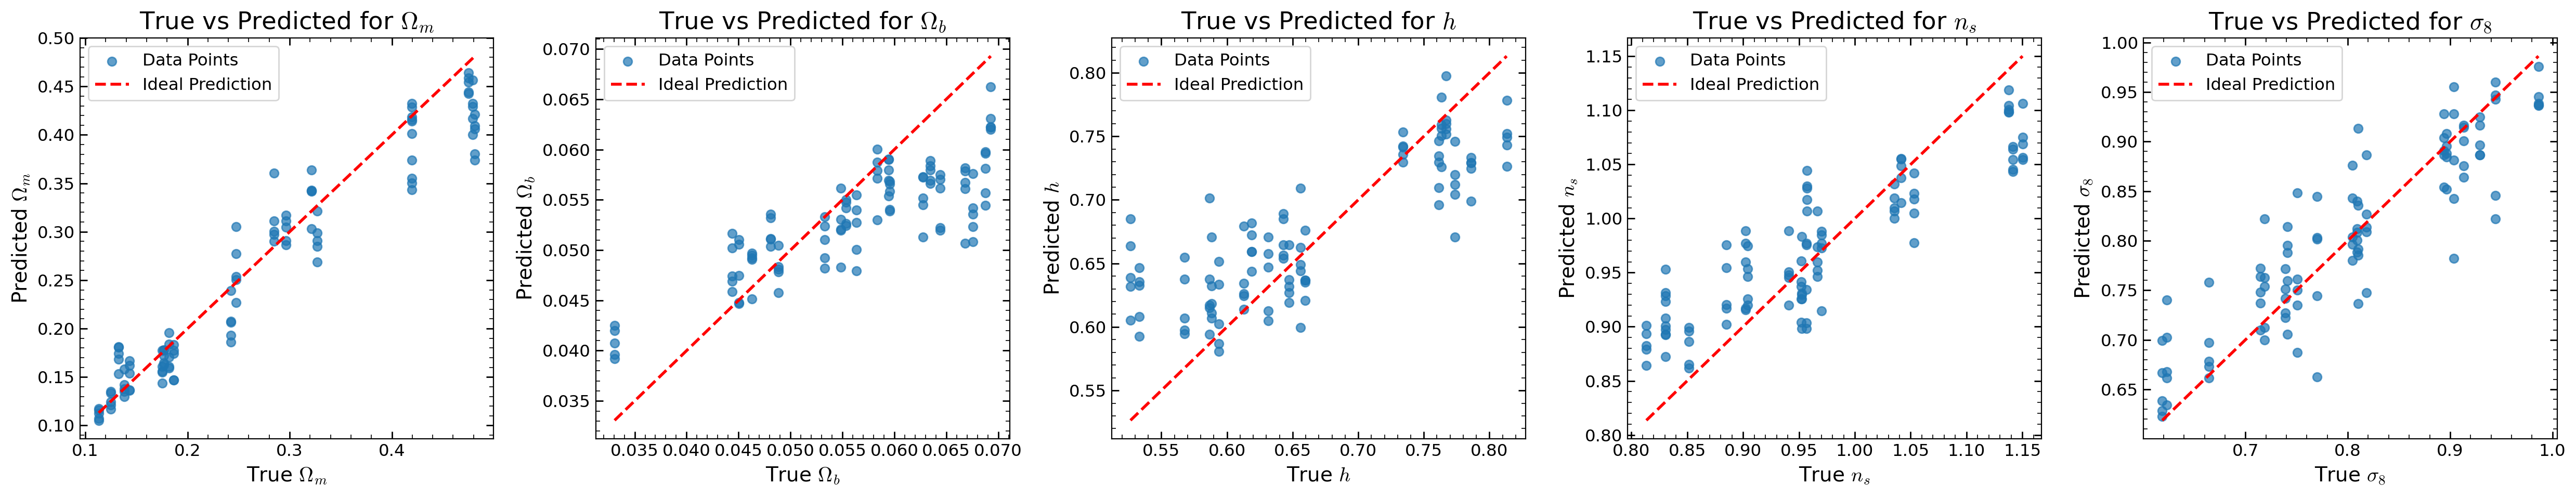

In [41]:
# Select a subset of the data for visualization
subsample = 100
xtrain_subset = xtrain[:subsample]
thetatrain_subset = thetatrain[:subsample]

# Predict using the trained model
predicted_values = multi_output_model.predict(xtrain_subset)

# Plot true vs predicted values for each target
num_targets = thetatrain.shape[1]
fig, axs = plt.subplots(1, num_targets, figsize=(
    5 * num_targets, 5), sharey=False)

for i, ax in enumerate(axs):
    ax.scatter(
        thetatrain_subset[:, i], predicted_values[:, i], alpha=0.7, label='Data Points'
    )
    ax.plot(
        [thetatrain_subset[:, i].min(), thetatrain_subset[:, i].max()],
        [thetatrain_subset[:, i].min(), thetatrain_subset[:, i].max()],
        'r--',
        label='Ideal Prediction'
    )
    ax.set_xlabel(f'True {target_names[i]}')
    ax.set_ylabel(f'Predicted {target_names[i]}')
    ax.legend()
    ax.set_title(f'True vs Predicted for {target_names[i]}')

plt.tight_layout()
plt.show()

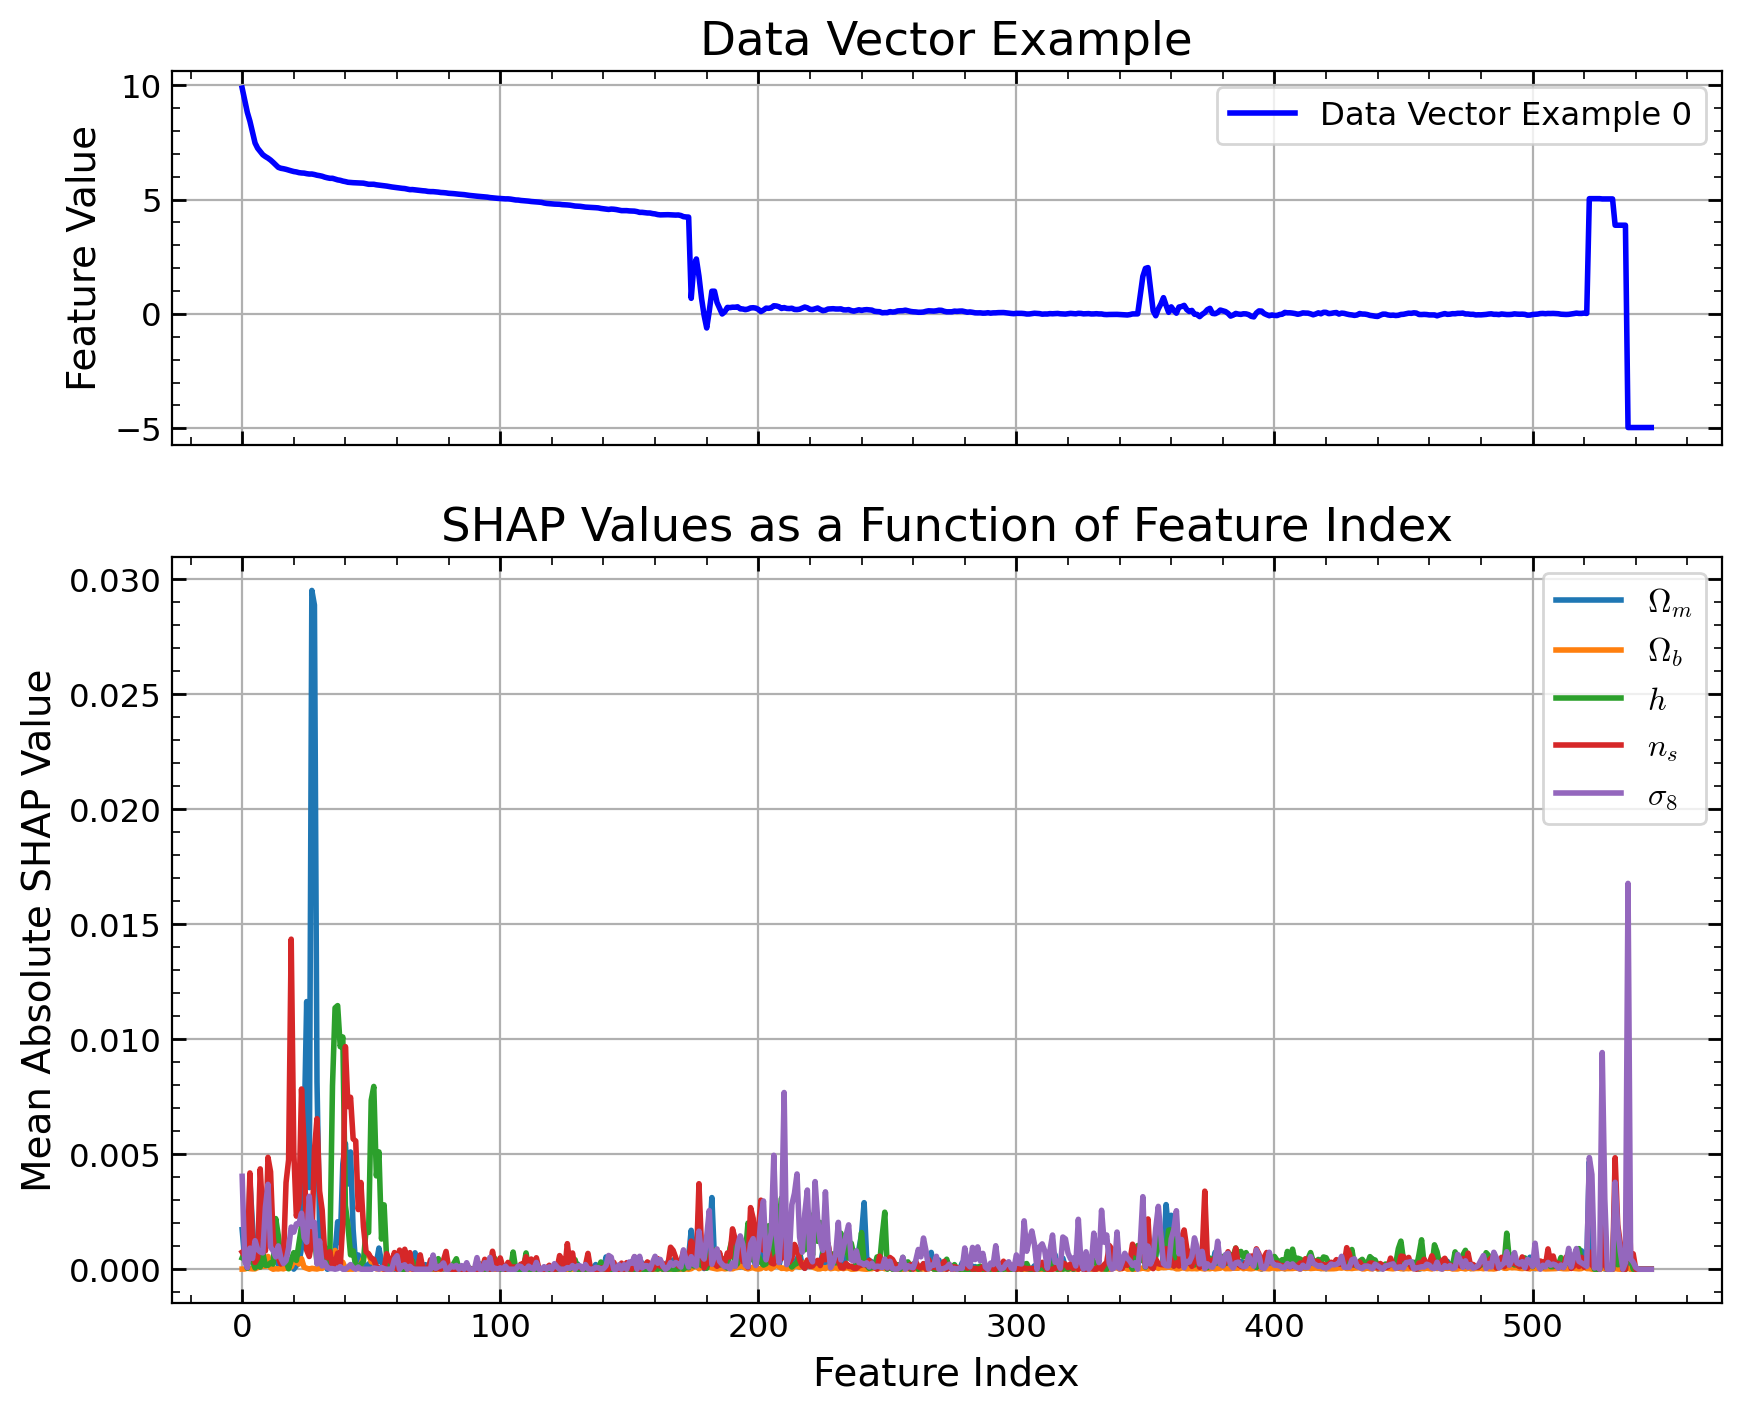

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True,
                        gridspec_kw={'height_ratios': [1, 2]})

# Top subplot: Data vector example
ind = 0
ax = axs[0]
ax.plot(range(xtest.shape[1]), xtest[ind],
        label=f'Data Vector Example {ind}', color='blue')
ax.set_ylabel('Feature Value')
ax.legend()
ax.grid()
ax.set_title('Data Vector Example')
for i in range(4):
    ax.axvline(i * Nk, color='k', ls=':', lw=0.5)
for i in range(3):
    ax.text(i * Nk + Nk / 2, 1.7, f'$P_{{{2*i}}}(k)$',
            horizontalalignment='center', fontsize=12, color='k')

# Bottom subplot: SHAP values as a function of feature index
ax = axs[1]
for i, estimator in enumerate(multi_output_model.estimators_):
    explainer = shap.TreeExplainer(estimator)
    shap_values = explainer.shap_values(xtrain)
    mean_shap_values = np.abs(shap_values).mean(axis=0)
    ax.plot(range(len(mean_shap_values)),
            mean_shap_values, label=f'{target_names[i]}')

ax.set_xlabel('Feature Index')
ax.set_ylabel('Mean Absolute SHAP Value')
ax.set_title('SHAP Values as a Function of Feature Index')
ax.legend()
ax.grid()

In [11]:
target_names = [r'$\Omega_m$', r'$\Omega_b$', r'$h$', r'$n_s$', r'$\sigma_8$']